# When Prediction Fails

## When all you have is a Hammer...

Between 2015 and 2020, Machine Learning went through massive democratization. Its proven usefullness in the fileds of computer vision and natrual language understanding, coupled with an initial lack of professionals in the area, provided the perfect oportunity for a machine learning teaching industry. Figures like Andrew Ng and Sebastian Thrun managed to teach machine learning to the world at rock bottom prices. At the sime time, on the software side, it became increasingly easier to fit a complex machine learning model (as you've already seen by the very few lines of code it took us to write an ML in the previous chapter). Tutorial about how to make inteligent systems sprung all over the internet.

![img](./data/img/when-prediction-fails/ml-in-5.png)

Building ML became so simple that you didn't even need to know how to code very well, nor the math behind the algorithms. In fact, you cold build wonders with the following 5 lines of Python.

```python
X_train, y_train, X_test, y_test =  train_test_split(X, y)

## instanciate the machine learning model
model = MachineLearningModel()

## Fit the ML model
model.fit(X_train, y_train)

# Make predictions on unseen data
y_pred = model.predict(X_test)

# Evaluate the quality of predictions
print("Performance", metric(y_test, y_pred))
```

For the most part, this is an amazing thing! I'm all in for taking valuable content and making it available. However, there is also a dark side to all of this. The new data scientists that where being formed where trained mostly in predictive modeling, since that is what ML primaly focus on solving. As a result, whenever those data scientists encountered a business problem, they tried to tackle it with, not suprisigly, predictive model. When they where indeed prediction problems, like the one we saw in the previus chapter, the data scientist usually suceeded and everyone got happy. However, there is an entire class of problems that are simply not solvable with prediction techiques. These are problem that are framed like "how much can I increase Y by changing X".

From my experience, these other type of problem is what management usually cares the most about. They often want to know how to increase sales, decrease cost or bring in more customers. Needless to say, they are not very happy wen a data scientist comes up with an answer to how to predict sales instead of how to increase it. Saddly, when evrything the data scientis knows is predictive models, this tends to happen a lot. As a boos of mine once told me: when all you have is a hammer, everything starts to look like a thumb. 

To fix that, I think that my job here is to equip you to solve this other class of problems. As you've might have guessed, they are causal in nature. What you are trying to do is estimate how something you can control (advertisement, price, customer service) afects or cause something you want to change (sales, number of customers, PNL). This seccond part of the book will focus on how to solve those problems. But first, I want to show you what hapens when you treat them like prediction problems and try to solve them with the traditional ML toolkit. The reason for that is that DS often say to me "OK, but although tackling causal problems with prediction tools is not the best idea, it surly helps something, no? It coul'd hurt trying". Well, as it turns out, it can. This chapter is here so that the next time you see data scientist with his shiny new hammer, you direct him here before he hurts someone's thumb.

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

from nb18 import ltv_with_coupons

## Who Wants a Coupon?

Let's take the same situation we saw on the previous chapter and add a little twist to it. Previously, we where trying to figure out the profitable from the non profitable customers. We framed that as a prediction problem: predicting customer profitablity. We could then build a machine learning model for that and use it to choose who we would do business with: only the customers we predicted to be profitable. 

Now, you have a new task. You suspect that giving coupons to new customers increase their engagement with your business and makes them more profitable on the long run. That is, they spend more and for a longer period. Your new assignment is to figure out how much should the coupon value be (where zero is no coupon). With coupons, you are essentially giving away money for people to spend on your business. For this reason, they enter as a cost in your book account. Notice that if the coupon value is too high, you will probably loose money, since customers will buy all they need using only the coupons. On the flip side, if it's too low (or zero), you are not even giving coupons. 

The function `ltv_with_coupons` generates transaction data for us. As you can see, they have the same format as the one we saw previously, with one row per customer, a column for the cost of aquisition and columns for the transactions between day 1 and 30. 

In [2]:
transactions, customer_features = ltv_with_coupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,1,0,0,3,...,0,0,0,10,0,0,0,0,0,0
1,1,-61,0,2,3,0,0,0,0,2,...,0,2,0,0,0,31,0,0,0,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,22,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


As for the other part of the data, again, we have a customer identifier, the region the customer lives, the customer income and the customer age. In adition, we now ave a variable that is `coupons`, which tells us how much we've gave in coupons for that customer once they joines our company.

In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,1,1025,5,24
1,1,49,1649,5,26
2,2,7,2034,15,33
3,3,29,1859,15,35
4,4,0,1243,5,26


To process this data to a single dataframe, we will sum all the columns in the first table (that is, summing `CACQ` with the transactions).This will give us the `net_value` as is was computed in the previous chapter. After that, we will update the `net_value` to include the coupon cost.

In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            .merge(profitable, on="customer_id")
            ## include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,5,24,-100
1,1,49,1649,5,26,-16
2,2,7,2034,15,33,18
3,3,29,1859,15,35,-45
4,4,0,1243,5,26,-18


This processed data frame have all that we need. It has our target variable `net_value`, it has our customer features `region`, `income` and `age`, and it has the thing we want to optimise: coupons. Just to begin to understand how coupons can increase `net_value`, let's look at how they where given.

In [5]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

We can see that most of the coupons that where handed out had a value of 5 BRL, followed by the coupons with 10 BRL in value. We gave very few 15 BRL coupons or no coupons at all (zero value).

At this point in the analysis, **if this was a prediction problem** , we would probably split the dataset into a training and a test set to respectivly build and evaluate some policies. However, this is NOT a prediction problem. The final goal here is not to get a good prediction on customer profitability. Instead, is is to optimise coupons. To evaluate this optimization, we would have to know how things would have played out if we have given different coupons than the ones that where given. This is the sort of counterfactual "what if" question we've been studing under causality. But if we can't simply do cross validation (or train test split) what can we do to evaluate our optimization strategy? The real answer is very involved and so important that it deservers its own chapter. For now, since all this data is simulated, we can re-generate the data but changing the vouncher parameters. Then, we can see the observe how the `net_value` would have played out under a diferent policy. Let's see this in practice and I think it will become more clear.

## Simple Policy

As always, the first thing we should do whenever we encounter a new data problem is to ask ourselves "what is the simplest thing I can do that will already bring value?". For , Ithis specific case, the simplest thing is to look back on the data that we have and estimate the `net_value` for each coupon value. Then, check which coupon value is generating the highest `net_value` and give only that coupon value for every customer. 

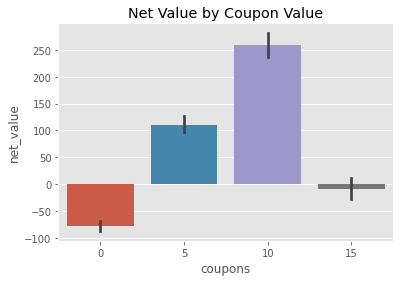

In [6]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value");

Doing that analysis, we can see that, on average, we loose money when the coupon value is 0 or 15 and we gain money for coupons of 5 and 10 BLR. The highest average appears when we have 10 BLR coupons, yielding us about 250 BLR in `net_value` per customer. Naturaly then, the simplest thing we can try is to give everyone 10 BLR in coupons ans see how would that play out.

To do that, the function `ltv_with_coupons` acepts as argument a 10000 array that contains the desired coupon for each of the 10000 customers on our database. To create this array, we will generate an array of ones with `np.ones` the size of our `coupons` array (10000) and multiply it by 10. Then, we will pass this array to the `ltv_with_coupons`. This will geneare a new dataset exacly like the one we had previously, but with every coupon value set to 10. We then process this data to get the net value under this proposed policy.

In [7]:
simple_policy = 10 * np.ones(customer_features["coupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)

customer_features_simple_policy = process_data(transactions_simple_policy,
                                               customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,10,24,17
1,1,49,1649,10,26,142
2,2,7,2034,10,33,9
3,3,29,1859,10,35,-40
4,4,0,1243,10,26,32


Just as a sanity check, let's see if the first few customer have that same feature as before. For the first one, the region is 1, the income is 1025 and the age is 24. If we scroll up a bit, we can see that it matches what we had before, so we are good to go.

To evaluate it, we can simply take the average net_value. 

In [8]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

464.556

As we can see, this simply policy is teling us we can get, on average, 464 BRL for each customer if we give them a 10 BLR coupon. This is massive. If we can have only 1000 customers we will already make more than almost halg a milions BRL. But can we do better? What if we use our shiny machine learnig hammer on this problem? Let's try this next.

## Policy With Model

To use ML, we will adapt what we did on the previus chapter. The idea is to build a ML model that predicts `net_value`, just like before, take those predictions and bins them into a defined number of bands

In [9]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict_bands(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])
        
        # discritize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False) 
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))
    
    return predict_bands

To evaluate the quality of our predictions, we will split the dataset into a training and a testing set. Notice here that we are here evaluating the quality of the prediction, NOT of the policy.

In [10]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

Now, let's train our model and make 5 bands with its predictions.

In [11]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(1)
model = model_bands(train, features, target, model_params, n_bands=5)

After training our model, we can use it to make predictions, passing it a dataframe. The result will also be a data frame whith 2 new columns: `predictions` and `pred_bands`.

In [12]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,3,567,5,27,-144,-17.433264,1
5910,5910,35,647,5,25,-62,-17.433264,1
1950,1950,43,2953,15,33,-142,326.474165,5
2119,2119,20,2860,5,27,-92,43.624013,3
5947,5947,45,589,5,26,-94,-6.570707,2


Now, to see the predictive power of ou model, we can look at the \\(R^2\\) for both training and test set.

In [13]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.3556912122241016
Test Score:,  0.3301683687600404


But this performance is only the predictive performance. What we really want to know is if this model can make us money. To do so, let's make a policy. The idea here is very similar to what we saw on the previus chapter. We will argue that each prediction band will contain different type of customers with regard to the `net_value`, the thing we are predicting. Then, for each type of customes as we defined, we will see which decision - coupon value in our case - is the best one. To do so, we can group our data by prediction band and coupon value and plot the `net_value`.

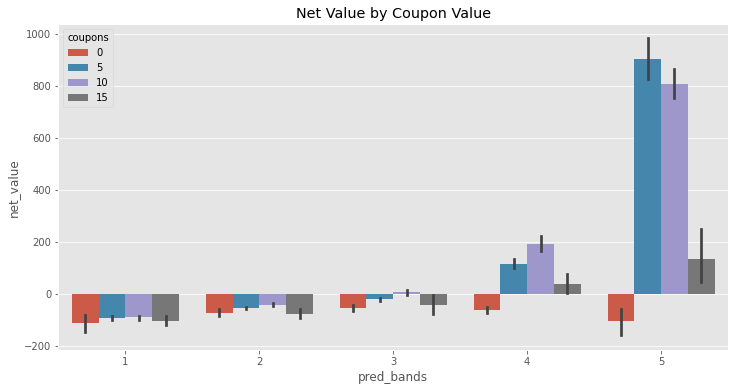

In [14]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value");

This plot is very interesting. Notice how the optimal decision changes across prediction bands. For band 1, 2, 3 and 4, the best thing to do is to give 10 BLR in coupons. And for band 5, the best thing is 5 BRL coupons. This means that this policy is very much like the simple one, exept for the last band.

We can code that policy with a couple of `if ... then ...` statement, but I'll show a more general approach. First, we will group our customers by band and coupon value and take the `net_value` for each group, much like the plot above.

In [15]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "coupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-112.676768
1,1,5,-94.653568
2,1,10,-91.997611
3,1,15,-104.333333
4,2,0,-74.698113
5,2,5,-54.582198
6,2,10,-42.217778


Then, we will group only by band and take the `net_value` rank for each row. This will order the rows acording to `net_value` where 1 is the worst net value in that band and 4 is the best net value.

In [16]:
pred_bands["max_net"] = (pred_bands
                         .groupby(['pred_bands'])
                         .agg({"net_value": "rank"}))


pred_bands.tail(8)

,pred_bands,coupons,net_value,max_net
12,4,0,-62.371429,1.0
13,4,5,115.491844,3.0
14,4,10,189.922705,4.0
15,4,15,37.584677,2.0
16,5,0,-105.000000,1.0
17,5,5,901.980854,4.0
18,5,10,805.830830,3.0
19,5,15,134.088608,2.0


Next, we will keep only the greatest `net_value` per band.

In [17]:
best_coupons_per_band = pred_bands.query("max_net==4")[["pred_bands", "coupons"]]

best_coupons_per_band

,pred_bands,coupons
2,1,10
6,2,10
10,3,10
14,4,10
17,5,5


Finally, to build our policy, we will take that small table above and join it back on the original table using the band as the key. This will pair each row in the original dataset with what we think is optimal coupon value, acording to this policy. The, we sort the rows according to the `customer_id` so that we keep the same ordering we had previusly.

In [18]:
coupons_per_id = (model(customer_features)
                 .drop(columns=["coupons"])
                 .merge(best_coupons_per_band, on="pred_bands")
                 [["customer_id", "coupons"]]
                 .sort_values('customer_id'))

coupons_per_id.head()

,customer_id,coupons
0,0,10
2038,1,10
3982,2,10
2039,3,10
5960,4,10


To evaluate our policy, we extract the coupons column and pass it to the `ltv_with_coupons` function. It should return the original data frame but with our coupons value and updates `net_income`. Here is where the ordering in important.

In [19]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model,
                                                customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,10,24,-77
1,1,49,1649,10,26,-9
2,2,7,2034,10,33,9
3,3,29,1859,10,35,49
4,4,0,1243,10,26,16


Just doing a sanity check again, we can see that the first customer is still the one with region 1, income 1025 and age 24. Now, to evaluate our policy, we can see the `net_value` mean for this new dataset, where the coupons where given as we defined by the policy.

In [20]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

366.891

The last thing to do is to compare it with te simple policy:

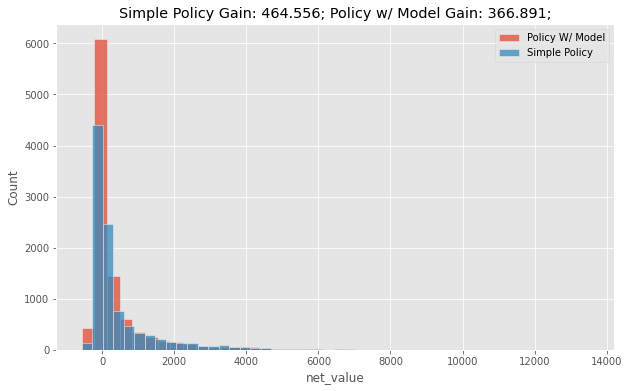

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");

Here is where most Data Scientist fall of the chair. The policy with the model has an average `net_income` which is 100 BRL worse than that of the simple policy. How can a model that is good at predicting `net_value` not be good for a strategy that aims maximises `net_value`? Surly, there must be some bug at the code. You are clearly mistaken. This cannot be! Well, as it turns out, there is a perfecly reasonable and simple explanation for it. However, the answer to this question is so inportant that I think is worth going deep into it.

## Hammering Your Thumb with Predictions

The short answer lies in understanding what we want with this policy, namely, to optimize `net_value` by playing with the coupon values. If we where to put it in an image, it's not crazy to thing that `net_value` will have a quadratic shape on coupons: as we increase the cupon value `net_value` first increases, then it reaches a maximun point. After that, any aditional coupon value will cost more than the value it brings.

![img](./data/img/when-prediction-fails/opt-deriv.png)

Finding the optimal coupon value then equal to finding the maximun of the `net_value` function. We can do this by diferentiating the function and seting it to zero (secon plot). However, real world data doesn't come with an underlying function we can diferentiate. In practice, what we do is test multiple coupon values and see which one yields the best `net_value`. This is exacly what our simple policy does. One VERY important thing to notice here is that this techique assumes that there is causal effect from coupon value to `net_value`. In other words, it must be the case that coupons causaly influences `net_value`, otherwise we could't use it as an optimization lever.

Contrast this to what the model based policy does. First, the model based policy fits machine learning model to predict for `net_value`. Then, it partitions the space acording to the predictions. If the model is good, this is aproximatly equal to partitioning the space by `net_value` itself, just like in the following plot.

![img](./data/img/when-prediction-fails/model-opt.png)

The better the prediction, the more this partitioning of the space aproaches partitioning on the target variable, `net_income`. Pay very close attention to what happens when you do that. Essentially, you are spliting the data into sets where `net_value`, the thing you've predicted, doesn't change! And that makes total sense. If your model is good at predicting, groups of points that have the same prediction will also have the same `net_value`. 

So far, so good, but look at what this does to the percieved function of `net_value` on coupons. It flattens it to have no slope at all. From the predictive point of view, this is awsome. It means that your model has captured all the variation on `net_income`. However, from the policy perspective, this is terrible, because there is no variance in `net_income` left for us to see how would it change given different coupon values. Without this variance in `net_income`, it would look like changing the coupon values has no effect on `net_income`, leaving us no room for optimization. 

To sumarise it in more general terms, whenever we want to optimise some \\(Y\\) using tome \\(T\\) variable, predicting \\(Y\\) will not only help, it will hurt our policy, since data partitions defined by the prediction will have limited \\(Y\\) variance, hindering our capacity to estimate how \\(T\\) changes \\(Y\\), \\(\frac{\delta Y}{\delta T} \\).

The key to fixing this mistake lies in ajusting our objetive to what we realy want. Instat of estimating \\(Y\\) out of \\(X\\), which is what prediction does, we need to estimate \\(\frac{\delta Y}{\delta T} \\) out of \\(X\\). Easier said than done. As you've might have guesses already, this is a causal problem. And, as it is natural of causal problems, we can't observe our quantity of interest \\(\frac{\delta Y}{\delta T} \\). You simply cannot observe how `net_income` would change if we changed the cupon value because we only observe one istance of coupon per customer. We can never know what would have hapened under if some different coupon value had taken place.

This charactirsitic of causal problems lead to further question: how can I know if my model is any good if I can't see what it is supposednly estimating? How can I validate a model like that? Those are fair questions and we shall answer them in time. Meanwile, keep in mind that, as we change our focus from estimating \\(Y\\) to estimating \\(\frac{\delta Y}{\delta T}\\), lots of things will have to change acordingly and the traditional ML toolkig will need some adaptation.